# Machine Learning Parcial 1: Clasificador Binario
Ivan Perez - \
John Guzman - 201713338

## Funciones y Librerias
### Importe de librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

### Funciones auxiliares

In [2]:
## Calculo de los IV (Funcion sacada de https://www.kaggle.com/code/puremath86/iv-woe-starter-for-python/notebook)
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    #print('El IV de esta variable es:',iv)
    #print(df[feature].value_counts())
    return iv, data

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta')
    plt.xlabel('Predicción')

In [4]:
def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = 'gp' + '_' + col
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

In [5]:
# Codificación One-Hot
def convert_dummy(df, feature,rank=0):
    pos = pd.get_dummies(df[feature], prefix=feature)
    mode = df[feature].value_counts().index[rank]
    biggest = feature + '_' + str(mode)
    #pos.drop([biggest],axis=1,inplace=True)
    df.drop([feature],axis=1,inplace=True)
    df=df.join(pos)
    return df

## Preprocesamiento

In [6]:
# Se obtienen los datos de los archivos de texto plano
xtrain = pd.read_csv("datos/xtrain.txt", sep="   ", header=None, engine='python')
ytrain = pd.read_csv("datos/ytrain.txt", sep="   ", header=None, engine='python')

In [7]:
# Creo un dataframe donde agrego la etiqueta de cada dato
data_labeled = xtrain.copy()
data_labeled.columns = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",  "N", "O", "P"]
data_labeled["class"] = ytrain
data_labeled.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,class
0,40572.0,725.331,250.71401,206.47193,1.214276,0.567264,40900.0,227.28369,0.767479,0.991980,0.969089,0.906546,0.006179,0.002574,0.821825,0.997923,1.0
1,38180.0,740.017,272.92339,178.76282,1.526735,0.755635,38709.0,220.48194,0.718669,0.986334,0.876118,0.807853,0.007148,0.001878,0.652626,0.996387,0.0
2,46827.0,808.608,300.96747,198.95893,1.512712,0.750329,47295.0,244.17614,0.781766,0.990105,0.899974,0.811304,0.006427,0.001718,0.658214,0.995688,0.0
3,72058.0,1035.943,397.71702,233.41022,1.703940,0.809677,73724.0,302.89783,0.764541,0.977402,0.843763,0.761591,0.005519,0.001145,0.580021,0.988322,1.0
4,80886.0,1136.801,391.65449,263.80113,1.484658,0.739136,82299.0,320.91627,0.719492,0.982831,0.786528,0.819386,0.004842,0.001346,0.671394,0.996790,1.0


In [8]:
#Se agregan las etiquetas a los datos de entrenamiento
xtrain.columns = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",  "N", "O", "P"]

In [9]:
#Se crea el data frame para guardar el calculo de los IV
ivtable=pd.DataFrame(data_labeled.columns,columns=['variable'])
ivtable['IV']=None
ivtable.drop(ivtable[ivtable['variable'] == 'class'].index, inplace=True)

### Analisis de Descriptores
Para hacer el analisis de los descriptores, primero se realizó una agrupación de cada descriptor teniendo en cuanta la repartición de los datos. Posteriormente, se hizo el calculo del Information Value (IV) de cada grupo de los descriptores, con el fin de ver los rangos más relevantes para hacer la predicción. Finalmente, se realizó la codificación one-hot de modo que se tengan los datos en limpio para posteriormente hacer la predicción con el modelo seleccionado.

Adicionalmente, se verifica si el IV de un sub-grupo de un descriptor es mayor a 0.1 con el fin de guardar este descriptor para hacer la predicción.

In [10]:
descriptores = []
for col in data_labeled.columns:
    if col != "class":
        data_labeled[col] = data_labeled[col]
        data_labeled = get_category(data_labeled,col, 5, ["lowest","low","medium","high","highest"])
        col_name = 'gp_'+col
        iv, data = calc_iv(data_labeled,col_name,'class')
        #print(data.head())
        ivtable.loc[ivtable['variable']==col,'IV']=iv
        data_labeled = convert_dummy(data_labeled,col_name)
        for index, row in data.iterrows():
            if row['IV'] >= 0.1:
                des_name = row['Variable'] + '_' + row['Value']
                descriptores.append(des_name)
descriptores

['gp_A_low',
 'gp_A_lowest',
 'gp_B_medium',
 'gp_C_low',
 'gp_C_medium',
 'gp_D_low',
 'gp_D_lowest',
 'gp_E_high',
 'gp_E_lowest',
 'gp_F_medium',
 'gp_G_low',
 'gp_G_lowest',
 'gp_I_high',
 'gp_I_low',
 'gp_I_lowest',
 'gp_L_high',
 'gp_L_lowest',
 'gp_L_medium',
 'gp_M_high',
 'gp_M_low',
 'gp_M_medium',
 'gp_N_high',
 'gp_O_high',
 'gp_O_lowest']

In [11]:
#IV de los descriptores originales
ivtable=ivtable.sort_values(by='IV',ascending=False)
ivtable

,variable,IV
12,M,4.778054
3,D,1.880769
14,O,1.85994
11,L,1.851856
4,E,1.77303
6,G,1.682043
0,A,1.663025
5,F,1.081257
1,B,0.81068
8,I,0.646835


In [12]:
#Datos de entrenamiento con los descriptores con IV >= 0.1
xtrain_iv = data_labeled[descriptores]

### Separación de los datos

In [13]:
#Separacion de los datos
xtrain_split, xtest, ytrain_split, y_test = train_test_split(xtrain_iv, ytrain, test_size=0.3, random_state=0)

## Selección de modelo
### Selección con GridSearch
Con el fin de buscar el modelo más apropiado para realizar la predicción sobre los datos dados, se realizó una busqueda de los hiperparametros del modelo mediante el uso de GridSearch. Para esto, se defienieron listas con los posibles hiperparametros del modelo, siendo estas tres listas: el numero de neuronas en la capa oculta ($hiden\_layer$), la función de activación ($activation\_list$) y el solver a usar en el modelo ($solver\_list$). Una vez definidas estas listas se crea un diccionario ($param\_grid$) con esta información, para pasarlo al GridSearchCV.

In [14]:
hiden_layer =  [(1,), (2,2), (6, 4), (10,5), (10,10), (50,50)]
activation_list = ['identity', 'logistic', 'tanh', 'relu']
solver_list = ['lbfgs', 'sgd', 'adam']
param_grid = {'hidden_layer_sizes': hiden_layer, 'activation': activation_list, 'solver': solver_list}

In [15]:
calsificadorMLP = MLPClassifier()
modeloMLP = GridSearchCV(calsificadorMLP, param_grid)
modeloMLP.fit(xtrain_split,ytrain_split) 
print("Mejores parametros: {}".format(modeloMLP.best_params_)) 
print("Mejor cross-validation score: {:.2f}".format(modeloMLP.best_score_))

Mejores parametros: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'solver': 'lbfgs'}
Mejor cross-validation score: 0.96


### Prueba del modelo
Una vez realizada la busqueda de los hiperparametros, se obtuvo que:
- hidden_layer_sizes: (10, 10)
- activation: tanh
- solver: lbfgs

Por lo que se procede a crear el modelo con estos hiperparametros y a probarlo con los datos de entrenamiento separados en entrenamiento y test.

Exactitud 0.94741
Precision 0.98876
Sensibilidad 0.90588
      0     1
0  1326    14
1   128  1232


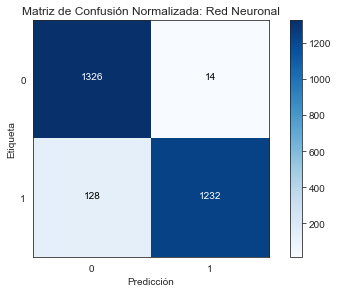

In [22]:
model = MLPClassifier( hidden_layer_sizes=(10, 10), activation='tanh', solver='lbfgs') # Inicialice un modelo de red neuronal con 2 capas escondidas x 20 neuronas en cada capa y función de activación ReLu #
model.fit( xtrain_split, ytrain_split ) # Ajuste el modelo con los datos del conjunto A #
y_predict = model.predict( xtest ) # Realice la predicción de etiquetas con los datos de prueba del conjunto A #

print(f'Exactitud {round(accuracy_score(y_test, y_predict),5)}')
print(f'Precision {round(precision_score(y_test, y_predict),5)}')
print(f'Sensibilidad {round(recall_score(y_test, y_predict),5)}')
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']

plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes=class_names, 
                      title='Matriz de Confusión Normalizada: Red Neuronal')

## Entrenamiento y predicción final
Finalmente, una vez se tiene el modelo seleccionado, se procede a entrenarlo con la totalidad de los datos de entrenamiento y a realizar la predicción sobre los datos de prueba proporcionados

### Preprocesamiento datos test

In [17]:
xtest_final = pd.read_csv("datos/xtest.txt", sep="   ", header=None, engine='python')

In [18]:
data_labeled2 = xtest_final.copy()
data_labeled2.columns = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M",  "N", "O", "P"]
data_labeled2.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P
0,28395.0,610.291,208.17812,173.88875,1.197191,0.549812,28715.0,190.14110,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724
1,28734.0,638.018,200.52480,182.73442,1.097357,0.411785,29172.0,191.27275,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430
2,31091.0,638.558,210.48625,188.32685,1.117665,0.446622,31458.0,198.96304,0.786377,0.988334,0.958173,0.945254,0.006770,0.003334,0.893506,0.998640
3,31178.0,636.888,212.97593,186.56209,1.141582,0.482352,31520.0,199.24122,0.764110,0.989150,0.965900,0.935511,0.006831,0.003227,0.875180,0.999090
4,31202.0,644.454,215.64069,184.47168,1.168964,0.517871,31573.0,199.31789,0.779193,0.988249,0.944079,0.924306,0.006911,0.003112,0.854341,0.998693


In [ ]:
for col in data_labeled2.columns:
    data_labeled2[col] = data_labeled2[col]
    data_labeled2 = get_category(data_labeled2,col, 5, ["lowest","low","medium","high","highest"])
    col_name = 'gp_' + col
    data_labeled2 = convert_dummy(data_labeled2,col_name)

xtest_final = data_labeled2[descriptores]

### Predicción final

In [24]:
model = MLPClassifier( hidden_layer_sizes=(10, 10), activation='tanh', solver='lbfgs')
model.fit( xtrain_iv, ytrain )
y_predict_final = model.predict( xtest_final )
y_predict_final

array([0., 0., 1., ..., 0., 0., 0.])

In [25]:
np.savetxt('datos/ypredict.txt', y_predict_final, fmt='%d')